# **The Subscriber Segmenteer**
by [Andrew Yu](https://www.linkedin.com/in/andrewdyu/), [Norman Chen](https://www.linkedin.com/in/naiming-chen/), and [Cathy Chen](https://www.linkedin.com/in/cathy-chen-8b5480195/).

---

Check it out on [GitHub](https://github.com/YuDrew/strategic-subscriber-segmentation/).



# **Executive Summary**
---

## **Background & Objective**

In the space of content creation, subscribers rule above all else. With the release of new publishing platforms like Anchor (podcasts) and Substack (newsletters), a new wave of content creators is starting to emerge. As content niches mature, content creators will need to more heavily compete for advertisement deals and sponsorships, and in order to do so, it is imperative that they understand who their subscribers are. However, these new publishing platforms aren’t equipped with the right tools to help creators properly break down their audience by increasingly niche segmentation criteria. This makes it hard for creators to curate good content for their audience, and it’s doubly difficult to secure advertisement deals if they can only guess at their audience base. 

We hope to build the Startup Sub Sifter: a scalable model that can quickly and accurately categorize subscribers of entrepreneurship-focused content into useful categories (e.g.  investors vs startup operators vs students). Ideally, this tool should be:

1. cost-free considering that many creators are not yet monetized
2. relatively accurate and granular, and
3. repeatable OR continuously and automatically updated.

## **Data**

To build this model, we used a redacted subscriber snapshot of [Climate Tech VC](https://climatetechvc.substack.com/), a rapidly-growing Substack newsletter focused on climate innovation. The starting dataset consists 8662 website URLs and can be found [here]('https://raw.githubusercontent.com/YuDrew/strategic-subscriber-sorter/main/subscriber_websites.csv').

In order to transform this data into meaningful information,we pulled the text from the homepage of each website. The results of the initial scrape and cleaning can be found [here](https://raw.githubusercontent.com/YuDrew/strategic-subscriber-sorter/main/scraped_website_text.csv).

## **Findings**

## **Next Steps**
---

# Part 0: Notebook Setup
---

In [ ]:
%%capture
!pip install --upgrade gspread
!pip install flashtext
!pip install lxml
!pip install beautifulsoup4
!pip install htmlmetadata
!pip install -U gensim
!pip install pyldavis==2.1.2
!pip install requests_html

In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 133kB 4.0MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [ ]:
%%capture
# Important Data Libs
import pandas as pd
import numpy as np

import os

# Important Viz Libs
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.offline as offline
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Text Processsing
import re

# LDA Topic Modeling
from gensim import corpora
from gensim import matutils
from gensim.models import LsiModel, KeyedVectors, LdaModel
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.nmf import Nmf
from gensim.models import HdpModel

# LDA Visualization
import pyLDAvis

# Important Export Libs
import gspread

# Part 1: Initial Data, Processing, & EDA
---


## 1.4 Verifying Our Preprocessing

Now that we've done so much preprocessing, let's take a look at our data.

In [ ]:
english_cleaned_unique_df = pd.read_csv('https://raw.githubusercontent.com/YuDrew/strategic-subscriber-sorter/main/english_cleaned_unique.csv')
english_cleaned_unique_df = english_cleaned_unique_df[['url','text']].astype({'url':str,'text':str})
english_cleaned_unique_df 

,url,text
0,cornell.edu,cornell university private research university...
1,ida.ie,look new home business look far ireland perfor...
2,tolacapital.com,tola capital company engagement team contact s...
3,hearst.com,home hearst navigation skip content hearstlife...
4,buchanan.uk.com,home buchanan uk close story people advisory b...
...,...,...
1944,corpgov.net,corporate governance navigation corporate gove...
1945,knoweatall.co,curating recipe preference kuri build personal...
1946,petri.bio,petri provide custom capital support connectio...
1947,climatescape.org,discover organization solve climate change cli...


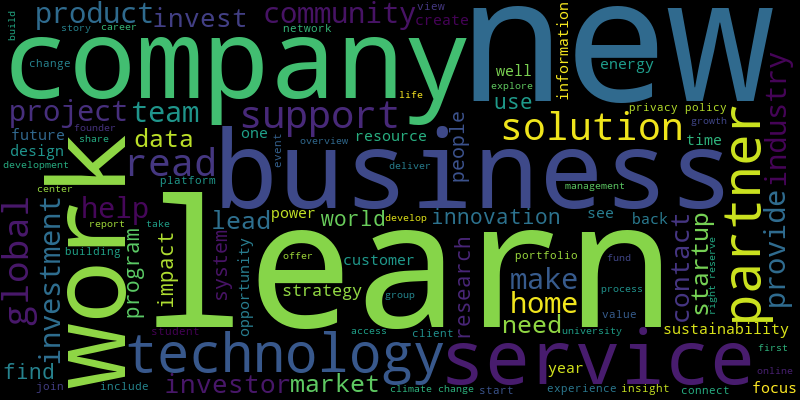

In [ ]:
from wordcloud import WordCloud

long_string = ','.join(list(english_cleaned_unique_df['text'].values))

wordcloud = WordCloud(background_color='black', \
                      max_words = 100, \
                      contour_width = 3, \
                      contour_color = 'steelblue', \
                      width = 800, height = 400).generate(long_string)

wordcloud.to_image()

In [ ]:
english_cleaned_all_df = pd.read_csv('https://raw.githubusercontent.com/YuDrew/strategic-subscriber-sorter/main/english_cleaned_all.csv')
english_cleaned_all_df = english_cleaned_all_df[['url','text']].astype({'url':str,'text':str})
english_cleaned_all_df 

,url,text
0,cornell.edu,cornell university private research university...
1,cornell.edu,cornell university private research university...
2,cornell.edu,cornell university private research university...
3,cornell.edu,cornell university private research university...
4,cornell.edu,cornell university private research university...
...,...,...
3498,corpgov.net,corporate governance navigation corporate gove...
3499,knoweatall.co,curating recipe preference kuri build personal...
3500,petri.bio,petri provide custom capital support connectio...
3501,climatescape.org,discover organization solve climate change cli...


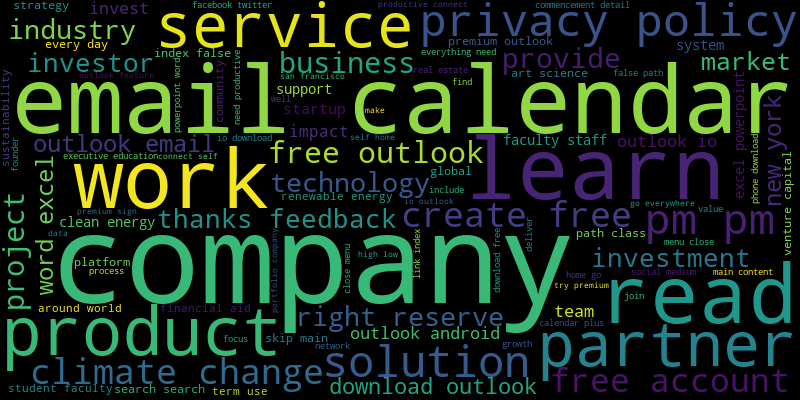

In [ ]:
from wordcloud import WordCloud

long_string = ','.join(list(english_cleaned_all_df['text'].values))

wordcloud = WordCloud(background_color='black', \
                      max_words = 100, \
                      contour_width = 3, \
                      contour_color = 'steelblue', \
                      width = 800, height = 400).generate(long_string)

wordcloud.to_image()

# Part 2: Clustering
---

With our new cleaned documents, we can begin theprocessing . In order 

## 2.1 K-Means Clustering [CATHY]

The first thing that comes to mind when we consider clustering is K-Means clustering. Unfortunately, we can't directly compute Euclidean distance between words, so we need to conduct some feature engineering in order to conduct K-Means clustering.

We opted to use `TF-IDF` (or Term Frequency-Inverse Document Frequency) to compute the importance of a word in a corpus, with the most relevant terms being the most important. The more times a word appears within a document, the stronger that word is (hence Term Frequency), but the more documents the word appears in, the less unique / salient that word is (hence Inverse Document Frequency).


### 2.1.1 Selecting the Right Data
Because of the way Inverse Document Frequency works, it's best for us to use TF-IDF on our `english_cleaned_unique_df` dataframe, rather than dataframes that have high repeats. Otherwise, all words associated with Cornell University might be unfairly underweighted.

In [ ]:
english_cleaned_unique_df

,url,text
0,cornell.edu,cornell university private research university...
1,ida.ie,look new home business look far ireland perfor...
2,tolacapital.com,tola capital company engagement team contact s...
3,hearst.com,home hearst navigation skip content hearstlife...
4,buchanan.uk.com,home buchanan uk close story people advisory b...
...,...,...
1944,corpgov.net,corporate governance navigation corporate gove...
1945,knoweatall.co,curating recipe preference kuri build personal...
1946,petri.bio,petri provide custom capital support connectio...
1947,climatescape.org,discover organization solve climate change cli...


### 2.1.2 Computing TF-IDF

TO-DO: Compute TF-IDF of the english_unique dataframe

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = english_cleaned_unique_df['text']
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names())
tf_idf.T.nlargest(5, 0)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1909,1910,1911,1912,1913,1914,1915,1916,1917,1918,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928,1929,1930,1931,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941,1942,1943,1944,1945,1946,1947,1948
cornell,0.737450,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.152607,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
ithaca,0.184727,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
university,0.175658,0.008493,0.0,0.0,0.0,0.0,0.0,0.169997,0.029416,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.092133,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002879,0.0,0.119719,0.116499,0.0,0.160157,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.035633,0.0,0.0,0.0,0.0,0.0,0.020699,0.0,0.0,0.0,0.0,0.0,0.0,0.008651,0.0,0.021595,0.0,0.0
slide,0.165428,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.033558,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
student,0.137451,0.000000,0.0,0.0,0.0,0.0,0.0,0.101349,0.000000,0.0,0.0,0.007591,0.0,0.0,0.0,0.0,0.123588,0.0,0.004881,0.0,0.0,0.0,0.01827,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021025,0.0,0.178435,0.121546,0.0,0.133676,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014008,0.0,0.0,0.0,0.0,0.0,0.0,0.031146,0.0,0.0,0.0,0.0,0.0,0.0,0.241650,0.0,0.0,0.0,0.0,0.0,0.129576,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


In [ ]:
tf_idf

,aa,aaa,aaac,aaavc,aachen,aachener,aacsb,aae,aakash,aaland,aalto,aamidor,aamir,aamodt,aan,aansturen,aantal,aapi,aarhus,aarkkariyam,aaron,aaronson,aarp,aarti,aarushi,aasha,aashirvaad,aave,aayush,ab,aba,ababa,ababax,aback,abacus,abajas,abalone,aban,abandon,abandonment,...,찾는,천명,최대,추구하는,캐피탈,테헤란로,통해,투자,투자가,투자기회를,투자를,투자섹터에서,투자시장의,투자의,투자자,투자자에게는,투자합니다,트렌드와,특히,패러다임을,포럼인,표준이,하는,한국,한국어,한국의,함께,해결을,해결하고자,헬스케어,혁신을,확장하고,환경,활동해,회사를,ﬁnancing,𝒂𝒓𝒆,𝒅𝒐,𝘔𝘢𝘳𝘬,𝘝𝘢𝘯𝘥𝘦𝘳𝘣𝘦𝘦𝘬𝘦𝘯
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Note that in the end, we want to categorize each website with a cluster, we will run kmeans on tf_idf instead of its transpose. In the table above, each entry represents the tf-idf value of the word (the column) in the particular website (the row). Note that since idf value punishes the number of different websites a word has appeared in, the idf value for each word is the same across websites; however, since the tf (term frequency) of each word is different across websites, each word will still have a different tf-idf value in each website and above matrix documents that.

We will categorize each website by the combination of the tf-idf values of every words.

### 2.1.3 Conducting K-Means

Conduct K-Means on the english_unique dataframe, using TF-IDF to calculate distance. 

In [ ]:
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(3,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(tf_idf)
    Sum_of_squared_distances.append(km.inertia_)

3
4
5
6
7
8
9
10
11
12
13
14


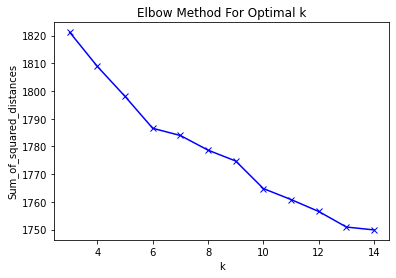

In [ ]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

We can see that the dip is around when k=13. We will use this value for our number of clusters

In [ ]:
km = KMeans(n_clusters=13)
km = km.fit(tf_idf)

### 2.1.4 Visualizing K-Means

We'll want to do the following: 
1. Vizualize our K-Means clusters;
2. Create word clouds for our clusters; and
3. Try to label our clusters ourselves.

In [ ]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

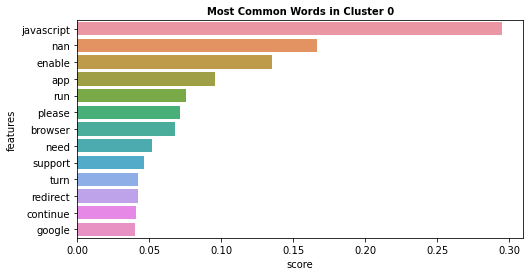

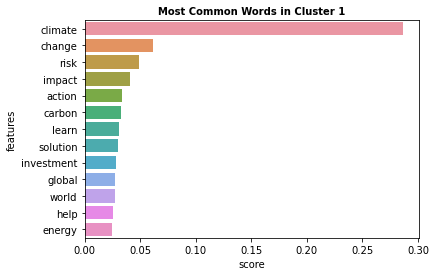

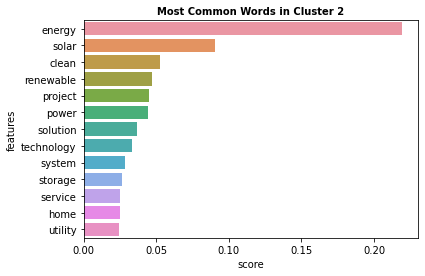

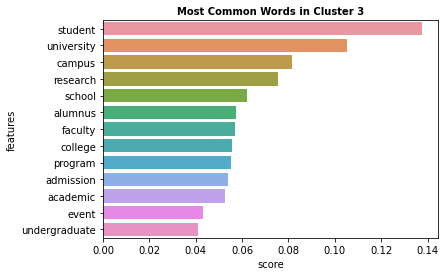

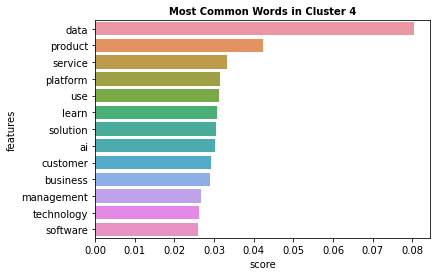

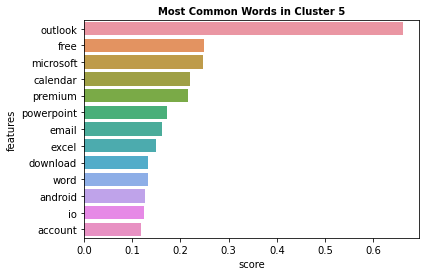

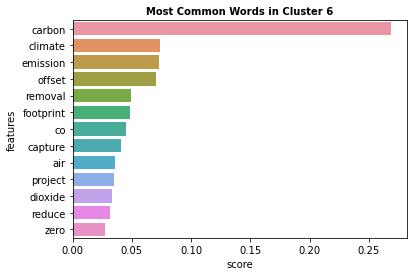

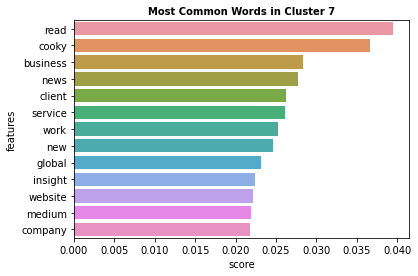

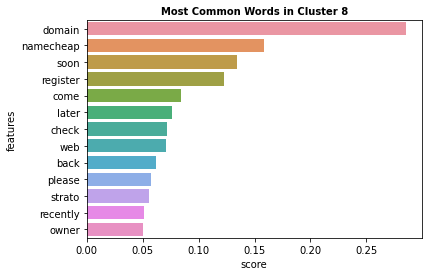

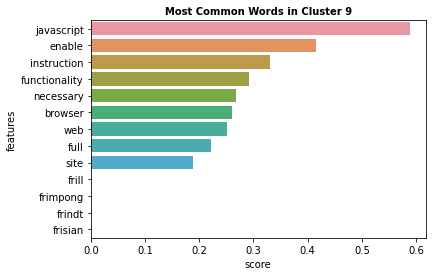

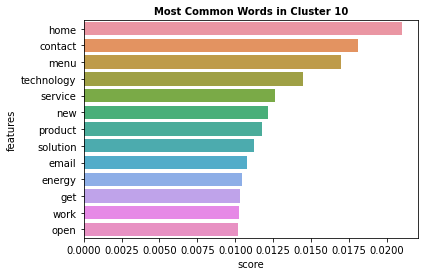

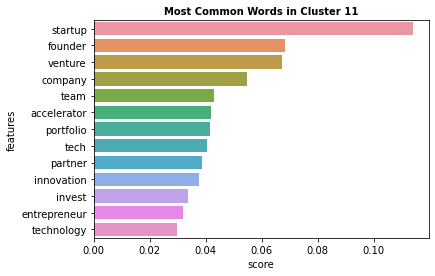

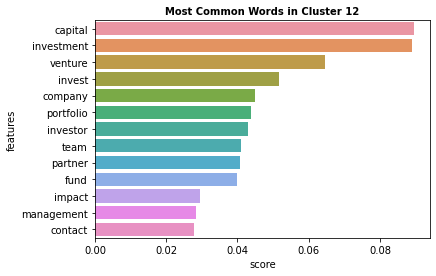

In [ ]:
final_df_array = tf_idf.to_numpy()
prediction = km.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

In [ ]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)
        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

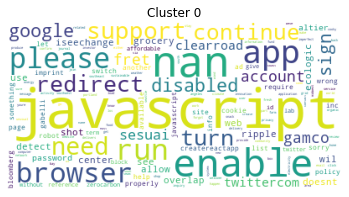

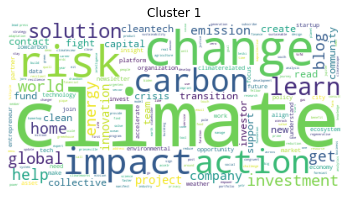

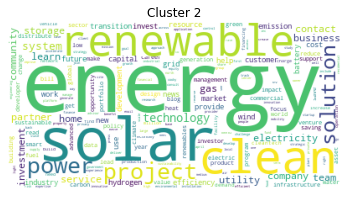

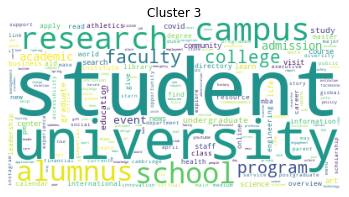

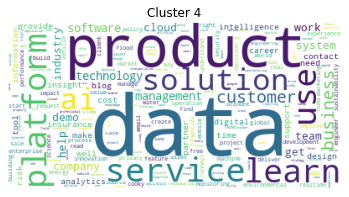

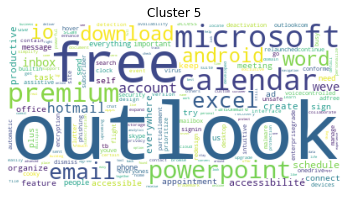

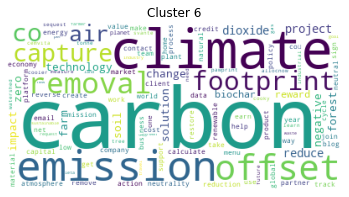

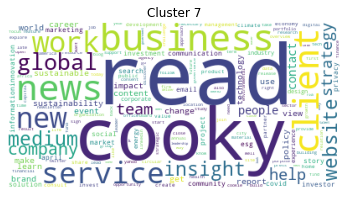

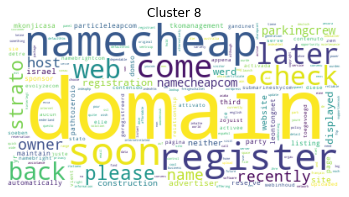

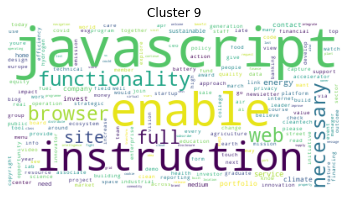

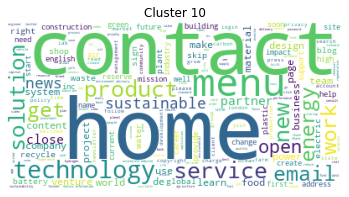

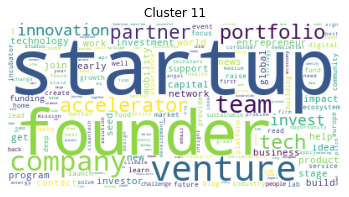

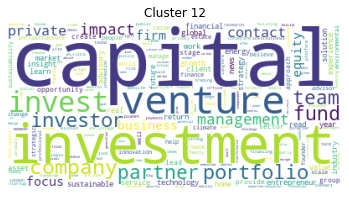

In [ ]:
centroids = pd.DataFrame(km.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)

### 2.1.5 Putting K-Means to the Test

Now that we have our K-Means model, we use these trained assignments to assign each of our documents (each website) to one of these clusters.

In [ ]:
labels = km.labels_ 
english_cleaned_unique_df['label'] = labels
english_cleaned_unique_df.head()

,url,text,label
0,cornell.edu,cornell university private research university...,3
1,ida.ie,look new home business look far ireland perfor...,7
2,tolacapital.com,tola capital company engagement team contact s...,4
3,hearst.com,home hearst navigation skip content hearstlife...,10
4,buchanan.uk.com,home buchanan uk close story people advisory b...,7


In [ ]:
labled_english_all_df = english_cleaned_all_df.merge(english_cleaned_unique_df, how='left', on='url')
labled_english_all_df.drop(columns=['text_y'], inplace=True)
labled_english_all_df.rename(columns={'text_x':'text'}, inplace=True)
labled_english_all_df[labled_english_all_df['label']==12]

,url,text,label
30,prospediacapital.com,automotive investment funding venture capital ...,12
32,cppib.com,cpp investment global investment management or...,12
33,cppib.com,cpp investment global investment management or...,12
34,cppib.com,cpp investment global investment management or...,12
35,cppib.com,cpp investment global investment management or...,12
...,...,...,...
3415,longspur.com,home global specialist leader new energy clean...,12
3418,planetfirst.partners,purposedriven european growth investor well pe...,12
3430,lieef.com,sustainable investment firm focus emerge infra...,12
3488,starquest-capital.com,starquest capital team portfolio documentation...,12


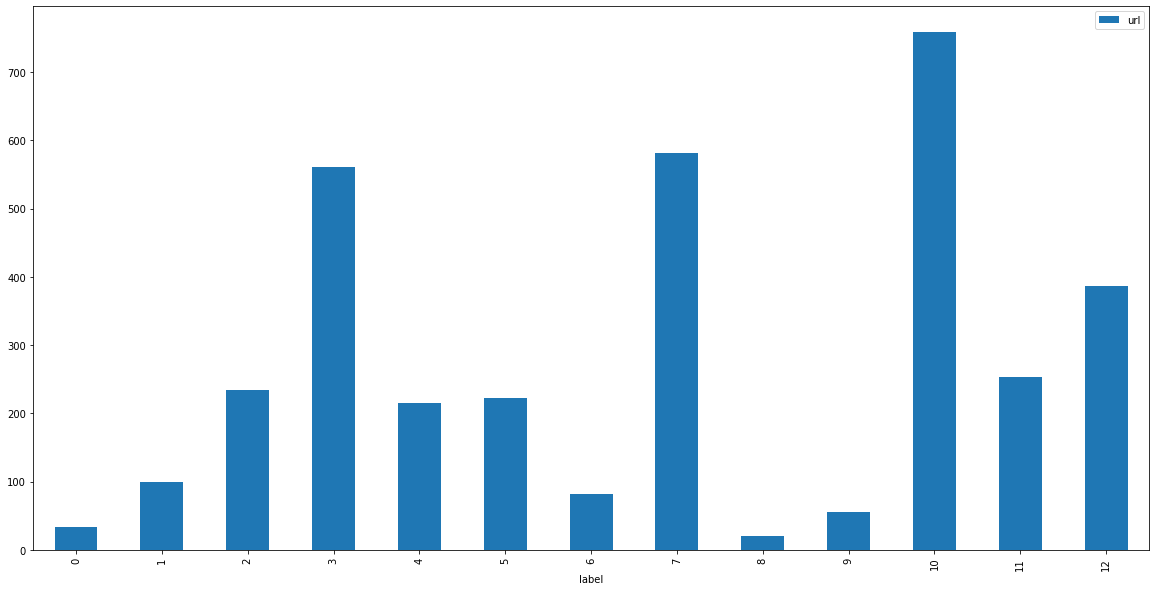

In [ ]:
distribution_df = labled_english_all_df.groupby(by='label').count().reset_index()
distribution_df.plot.bar(x='label', y='url', figsize=(20, 10))

We can see that cluster 3, 7, 10 and 12 are the most prominent clusters. If we look back to the most frequent words in each cluster, we can see that it makes sense those clusters are the most popular as cluster 3 are words associate with college, 7 are words associated with news, 10 are words associate with home, service or products and 12 are words associated with venture capitalism. They are in line with expected audience of our site.

### 2.1.6 Thoughts on K-Means

Overall, K-Means has a few distinct benefits as well as a few drawbacks. While K-Means clustering is a strong unsupervised learning method, traditional implementations are definitive / exclusive. That is to say, a given word or document is assigned to one cluster and one cluster only. Oftentimes, we'll find words that appear in multiple documents (especially words that might have different definitions depending on context). For these, we consider a probabilistic approach using Latent Dirchlet Allocation.

In general, we can see that our clusters are fairly acurate. In each cluster, we can see that the words are indeed coorelated to each other - suggesting that our metric - tf-idf - is a solid metric to calculate distance for k-means clusters. Using the final distribution of cluster, we can effectively center our marketing and newsletters to students and VCs with a focus on introducing new service and products, as well as providing news.